In [26]:
!pip install --user --upgrade pip

!pip install h5py
!pip install keras

Requirement already up-to-date: pip in c:\users\lucas\appdata\roaming\python\python36\site-packages (19.1.1)


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import h5py
import numpy as np

data_file = h5py.File('data.h5', 'r')

x_data = np.array(data_file['x_data'])
y_data = np.array(data_file['y_data'])

x_shape = x_data[0].shape

print(x_shape)
print(x_data.shape)
print(y_data.shape)

from sklearn.cross_validation import StratifiedShuffleSplit
stratSplit = StratifiedShuffleSplit(y_data, 1, test_size=0.3, random_state=1)
for train_idx, test_idx in stratSplit:
    x_train, y_train = x_data[train_idx], y_data[train_idx]
    x_test, y_test = x_data[test_idx], y_data[test_idx]
    
data_file.close()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(420, 40, 3)
(9248, 420, 40, 3)
(9248,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import numpy as np

def get_balance_data(y_data):
    zeros_args = np.argwhere(y_data == 0)
    ones_args = np.argwhere(y_data == 1)
    
    print("zeros:", len(zeros_args))
    print("ones:", len(ones_args))
    
    diff = len(zeros_args) - len(ones_args)
    print("diff:", diff)
    
    return zeros_args, ones_args, diff

In [3]:
get_balance_data(y_train);
get_balance_data(y_test);

zeros: 3237
ones: 3236
diff: 1
zeros: 1387
ones: 1388
diff: -1


In [4]:
from keras import layers
from keras import models
from keras import backend as K

K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=x_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(2, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(12, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01, noise_shape=None, seed=None))

model.add(layers.Dense(4, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01, noise_shape=None, seed=None))

model.add(layers.Dense(2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01, noise_shape=None, seed=None))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.
W0808 17:26:06.760671  3008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0808 17:26:06.776288  3008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0808 17:26:08.008153  3008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 17:26:08.023791  3008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 418, 38, 8)        224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 418, 38, 8)        32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 209, 19, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 207, 17, 4)        292       
_________________________________________________________________
batch_normalization_2 (Batch (None, 207, 17, 4)        16        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 103, 8, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 101, 6, 2)         74        
__________

In [5]:
from keras import backend as K

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    return recall

In [6]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 70

train_datagen = ImageDataGenerator(
                    height_shift_range=0.1,
                    brightness_range=[0.9, 1.0],                     
                    horizontal_flip=True,
                    vertical_flip=True)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

In [14]:
from keras import optimizers

#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', recall])

history = model.fit(x_train, y_train, epochs=200, batch_size=batch_size, shuffle=True, validation_split=0.3)
#history = model.fit_generator(train_generator, epochs=200, steps_per_epoch=(len(x_train))/batch_size, validation_split=0.3)

Train on 4531 samples, validate on 1942 samples
Epoch 1/200
4531/4531 [==============================] - 170s 37ms/step - loss: 0.2273 - acc: 0.9124 - recall: 0.9243 - val_loss: 0.4991 - val_acc: 0.7863 - val_recall: 0.6559
Epoch 2/200
4531/4531 [==============================] - 178s 39ms/step - loss: 0.2070 - acc: 0.9281 - recall: 0.9409 - val_loss: 0.4475 - val_acc: 0.8316 - val_recall: 0.8400
Epoch 3/200
4531/4531 [==============================] - 171s 38ms/step - loss: 0.2173 - acc: 0.9168 - recall: 0.9272 - val_loss: 0.2819 - val_acc: 0.8877 - val_recall: 0.8609
Epoch 4/200
4531/4531 [==============================] - 169s 37ms/step - loss: 0.2018 - acc: 0.9258 - recall: 0.9373 - val_loss: 0.3657 - val_acc: 0.8527 - val_recall: 0.8487
Epoch 5/200
4531/4531 [==============================] - 169s 37ms/step - loss: 0.1963 - acc: 0.9276 - recall: 0.9385 - val_loss: 0.2688 - val_acc: 0.8955 - val_recall: 0.9072
Epoch 6/200
4531/4531 [==============================] - 326s 72ms/step 

4531/4531 [==============================] - 101s 22ms/step - loss: 0.1090 - acc: 0.9629 - recall: 0.9657 - val_loss: 0.3560 - val_acc: 0.8780 - val_recall: 0.8908
Epoch 48/200
4531/4531 [==============================] - 97s 21ms/step - loss: 0.1106 - acc: 0.9625 - recall: 0.9701 - val_loss: 0.3352 - val_acc: 0.8841 - val_recall: 0.8940
Epoch 49/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.1106 - acc: 0.9623 - recall: 0.9643 - val_loss: 0.4852 - val_acc: 0.8548 - val_recall: 0.8917
Epoch 50/200
4531/4531 [==============================] - 94s 21ms/step - loss: 0.1126 - acc: 0.9616 - recall: 0.9637 - val_loss: 0.4526 - val_acc: 0.8651 - val_recall: 0.8492
Epoch 51/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.0983 - acc: 0.9647 - recall: 0.9685 - val_loss: 0.6284 - val_acc: 0.8229 - val_recall: 0.8399
Epoch 52/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.1024 - acc: 0.9653 - recall: 0.9668 - val_loss: 0.

4531/4531 [==============================] - 92s 20ms/step - loss: 0.1044 - acc: 0.9620 - recall: 0.9665 - val_loss: 0.5716 - val_acc: 0.8548 - val_recall: 0.8773
Epoch 94/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.0768 - acc: 0.9724 - recall: 0.9768 - val_loss: 0.4627 - val_acc: 0.8666 - val_recall: 0.8936
Epoch 95/200
4531/4531 [==============================] - 99s 22ms/step - loss: 0.0798 - acc: 0.9724 - recall: 0.9720 - val_loss: 0.6968 - val_acc: 0.8162 - val_recall: 0.7229
Epoch 96/200
4531/4531 [==============================] - 96s 21ms/step - loss: 0.0943 - acc: 0.9678 - recall: 0.9659 - val_loss: 0.4567 - val_acc: 0.8677 - val_recall: 0.8947
Epoch 97/200
4531/4531 [==============================] - 94s 21ms/step - loss: 0.0765 - acc: 0.9748 - recall: 0.9773 - val_loss: 0.3956 - val_acc: 0.8805 - val_recall: 0.8877
Epoch 98/200
4531/4531 [==============================] - 93s 20ms/step - loss: 0.0803 - acc: 0.9740 - recall: 0.9736 - val_loss: 0.4

4531/4531 [==============================] - 93s 20ms/step - loss: 0.0797 - acc: 0.9744 - recall: 0.9719 - val_loss: 0.7664 - val_acc: 0.8275 - val_recall: 0.9182
Epoch 140/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.0622 - acc: 0.9795 - recall: 0.9795 - val_loss: 0.5784 - val_acc: 0.8589 - val_recall: 0.9230
Epoch 141/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.0697 - acc: 0.9788 - recall: 0.9812 - val_loss: 0.4984 - val_acc: 0.8661 - val_recall: 0.8998
Epoch 142/200
4531/4531 [==============================] - 93s 20ms/step - loss: 0.0705 - acc: 0.9746 - recall: 0.9725 - val_loss: 0.8046 - val_acc: 0.8100 - val_recall: 0.8196
Epoch 143/200
4531/4531 [==============================] - 99s 22ms/step - loss: 0.0698 - acc: 0.9768 - recall: 0.9771 - val_loss: 0.6102 - val_acc: 0.8481 - val_recall: 0.8890
Epoch 144/200
4531/4531 [==============================] - 97s 21ms/step - loss: 0.0587 - acc: 0.9810 - recall: 0.9799 - val_loss

4531/4531 [==============================] - 93s 21ms/step - loss: 0.0493 - acc: 0.9826 - recall: 0.9794 - val_loss: 0.6636 - val_acc: 0.8239 - val_recall: 0.7535
Epoch 186/200
4531/4531 [==============================] - 93s 20ms/step - loss: 0.0693 - acc: 0.9786 - recall: 0.9777 - val_loss: 0.5896 - val_acc: 0.8476 - val_recall: 0.8224
Epoch 187/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.0460 - acc: 0.9857 - recall: 0.9864 - val_loss: 0.5196 - val_acc: 0.8682 - val_recall: 0.8478
Epoch 188/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.0616 - acc: 0.9821 - recall: 0.9840 - val_loss: 0.6714 - val_acc: 0.8373 - val_recall: 0.7805
Epoch 189/200
4531/4531 [==============================] - 92s 20ms/step - loss: 0.0439 - acc: 0.9841 - recall: 0.9846 - val_loss: 0.6299 - val_acc: 0.8424 - val_recall: 0.8071
Epoch 190/200
4531/4531 [==============================] - 94s 21ms/step - loss: 0.0604 - acc: 0.9812 - recall: 0.9803 - val_loss

In [9]:
model.evaluate(x_test, y_test, batch_size=batch_size)

2775/2775 [==============================] - 35s 12ms/step


[0.5104731813207403, 0.7974774760168952, 0.7043280244947554]

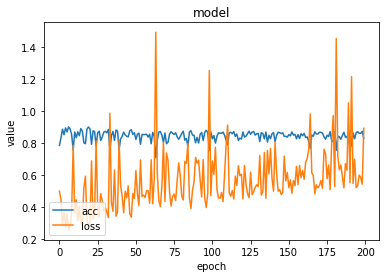

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title('model')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['acc', 'loss'], loc='lower left')
plt.show();

In [16]:
model.save("model3")

In [17]:
y_pred = [int(y>0.5) for y in model.predict(x_test)] 

[]

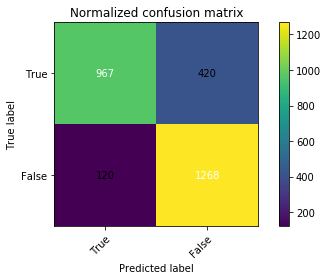

In [18]:
from sklearn.metrics import confusion_matrix


title = 'Normalized confusion matrix'

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=['True', 'False'], yticklabels=['True', 'False'],
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

plt.plot()

In [23]:
!pip install pydot

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [4]:
from keras import layers
from keras import models
from keras import backend as K

K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=x_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01, noise_shape=None, seed=None))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01, noise_shape=None, seed=None))

model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01, noise_shape=None, seed=None))

model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01, noise_shape=None, seed=None))

model.summary()

Using TensorFlow backend.
W0808 19:47:34.802245  7708 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0808 19:47:34.817769  7708 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0808 19:47:36.099716  7708 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 19:47:36.115234  7708 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 418, 38, 64)       1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 418, 38, 64)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 209, 19, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 207, 17, 32)       18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 207, 17, 32)       128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 103, 8, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 101, 6, 16)        4624      
__________